In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold

In [15]:
from utils import Imputer, MainFeatureExtractor, SimpleStatisticsExtractor, GeoFeatureExtractor

In [5]:
path = "data/"
data_start = pd.read_csv(path + 'train_events.csv')
video_start = pd.read_csv(path + 'video_info_v2.csv')
targets_start = pd.read_csv(path + 'train_targets.csv')

In [17]:
data, features = Imputer().fit_transform(data_start, video_start, targets_start)

for extractor in [MainFeatureExtractor(), SimpleStatisticsExtractor(), GeoFeatureExtractor()]:
    data, features = extractor.fit_transform(data, features)

features.shape

Applying SimpleStatisticsExtractor...


(180012, 166)

In [18]:
class CatboostEstimator:
    """
    Класс для обучения Catboost
    """

    def fit(self, X, y, n_splits, cat_features, score):
        """
        Разбивает данные на k фолдов со стратификацией и обучает n_splits катбустов
        """
        self.one_model = False
        self.models = []
        scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
            X_train = X.loc[train_index]
            y_train = y.loc[train_index]
            X_val = X.loc[val_index]
            y_val = y.loc[val_index]
            
            model = CatBoostClassifier(cat_features=cat_features, verbose=500, iterations=1000)
            model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val))
            
            self.models.append(model)
            y_pred = model.predict(X_val)
            scores.append(score(y_val, y_pred))
            print(f'model {ind}: score = {round(scores[-1], 4)}')
        
        scores = np.array(scores)
        print(f'mean score = {scores.mean().round(4)}, std = {scores.std().round(4)}')
        print(f'overall score = {(scores.mean() - scores.std()).round(4)}')
            
    
    def fit_select_features(self, X, y, cat_features, to_drop):
        """
        Обучает один катбуст и выполняет elect features
        """
        self.one_model = True
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.model = CatBoostClassifier(cat_features=cat_features, verbose=150, iterations=2000)
        
        self.model.select_features(X_train, y_train, verbose=500, eval_set=(X_val, y_val), steps=10,
                                  num_features_to_select=30, features_for_select=X.columns,
                                  algorithm='RecursiveByLossFunctionChange', train_final_model=True)

    def predict(self, X, cnt_classes):
        if self.one_model:
            return self.model.predict_proba(X)
        
        y_pred = np.zeros((X.shape[0], cnt_classes))

        for model in self.models:
            y_pred += model.predict_proba(X)
        y_pred /= cnt_classes
        y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred

In [19]:
from sklearn.metrics import f1_score, accuracy_score

In [20]:
def score_sex(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def score_age(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

In [33]:
cat_features = []
for i, col in enumerate(features.columns):
    if features[col].dtype in ['object', 'category']:
        cat_features.append(col)
        
cat_features

['region', 'favourite_cat']

In [34]:
catboost_sex = CatboostEstimator()
catboost_age = CatboostEstimator()

features_to_drop = [
    'viewer_uid',
    'age'
]

target_sex = 'sex'
target_age = 'age_class'

print('Sex model\n')

catboost_sex.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 features[target_sex],
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_sex)

print('\n\n\nAge model\n')

catboost_age.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 features[target_age],
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_age)

Sex model

Learning rate set to 0.096297
0:	learn: 0.6690190	test: 0.6686980	best: 0.6686980 (0)	total: 46ms	remaining: 46s
500:	learn: 0.4554847	test: 0.5028730	best: 0.5028730 (500)	total: 14.6s	remaining: 14.6s
999:	learn: 0.4120836	test: 0.5025092	best: 0.5021423 (795)	total: 28.9s	remaining: 0us

bestTest = 0.5021423271
bestIteration = 795

Shrink model to first 796 iterations.
model 0: score = 0.7518
Learning rate set to 0.096297
0:	learn: 0.6686692	test: 0.6692644	best: 0.6692644 (0)	total: 33.8ms	remaining: 33.8s
500:	learn: 0.4532560	test: 0.5054878	best: 0.5054878 (500)	total: 14.6s	remaining: 14.6s
999:	learn: 0.4091830	test: 0.5055300	best: 0.5051081 (625)	total: 29s	remaining: 0us

bestTest = 0.5051080962
bestIteration = 625

Shrink model to first 626 iterations.
model 1: score = 0.7482
mean score = 0.75, std = 0.0018
overall score = 0.7482



Age model

Learning rate set to 0.118144
0:	learn: 1.3465153	test: 1.3465937	best: 1.3465937 (0)	total: 98.2ms	remaining: 1m 38s
50

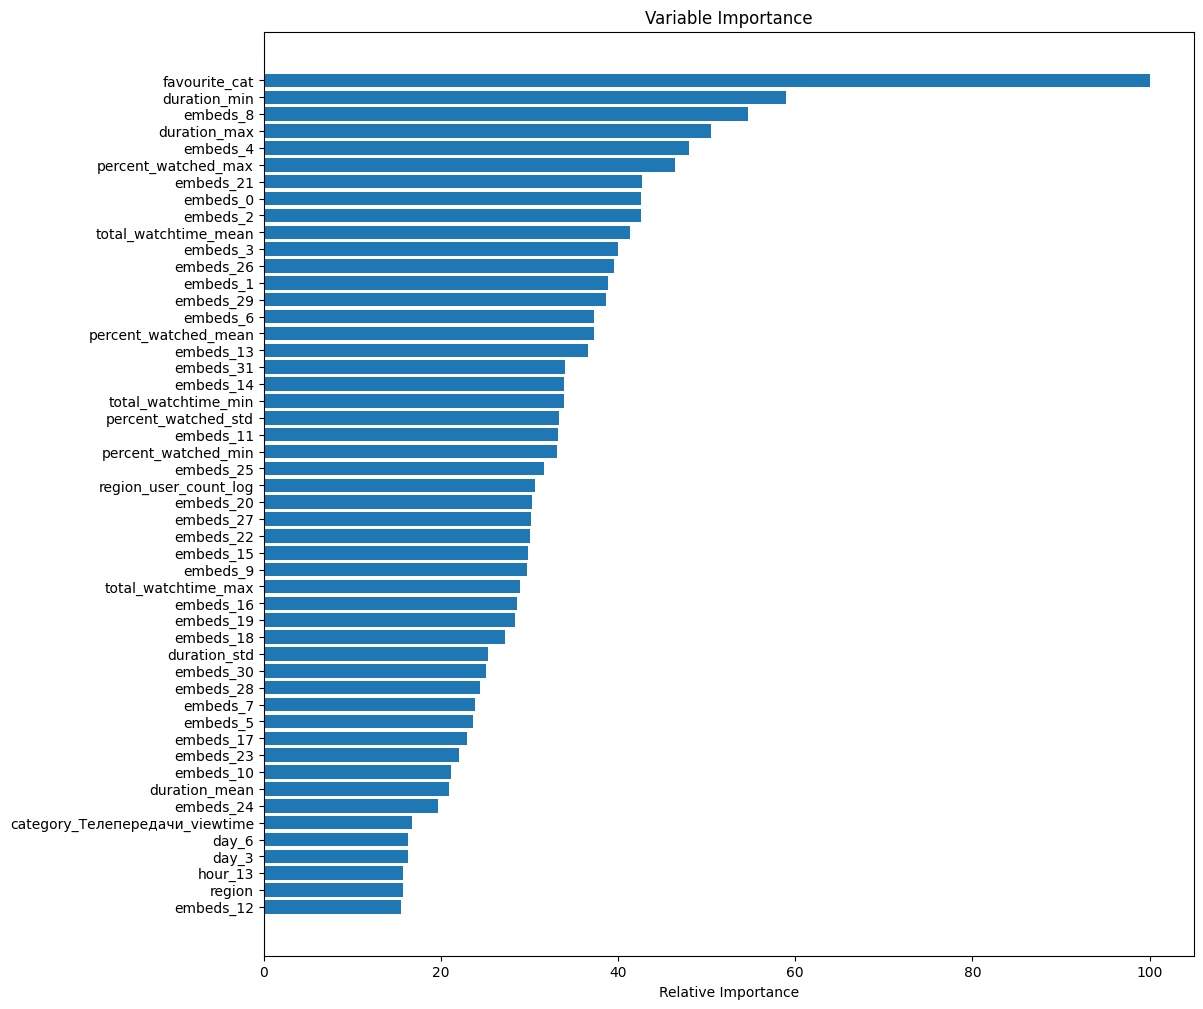

In [38]:
# Plot feature importances

def plot_importance(model, features, top=50):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 12))
    plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
    plt.yticks(pos[-top:], np.array(features.columns)[sorted_idx][-top:])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
plot_importance(catboost_age.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))